# Trotterization

Bloq for building a Trotterized unitary

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `TrotterizedUnitary`
Implement arbitrary trotterized unitary given any Trotter splitting of the Hamiltonian.

Given an arbitrary splitting of the Hamiltonian into $\Gamma$ terms

$$
    H = \sum_{\gamma=1}^\Gamma H_\gamma
$$

then the unitary $e^{-i t H}$ can be approximately implemented via a $p$-th order product
formula

$$
    S_p(t) = \prod_{v=1}^{\Upsilon}\prod_{\gamma=1}^\Gamma e^{-it a_{v,\gamma} H_{\pi_v(\gamma)}}
$$

where $\Upsilon$ is the number of `stages`, $a_{v, \gamma}$ are real numbers
and $\pi_v(\gamma)$ is a permutation of the Hamiltonian term labels.

In practice, to construct the unitary we adopt the convention from the second reference
which expands the product above and merges neighbouring unitaries where
possible.
In particular, the trotterized unitary can be specified by

$$
    S_p(t) = \prod_{k}^M e^{-it c_k H_{l_k}}
$$

where the coefficients $c_k$ are real numbers and $l_k$ is an integer
indexing which term of the Hamiltonian to apply.

For example, the second order Suzuki splitting would have indicies $(l)$ = (0, 1, 0)
and coeffs = $(c)$ = (0.5, 1, 0.5), which would build

$$
    e^{-i \frac{t}{2} H_0} e^{-i t H_1} e^{-i \frac{t}{2} H_0}
$$

#### Parameters
 - `bloqs`: A tuple of bloqs of length $\Gamma$ which implement the unitaries for each term in the Hamiltonian. Each bloq should be a frozen attrs dataclass, have an `angle` parameter. All bloqs should have the same signature.
 - `indices`: A tuple of integers which specifies which bloq to apply when forming the unitary as a product of unitaries.
 - `coeffs`: The coefficients $a$ which appear in the expression for the unitary.
 - `timestep`: The timestep $t$. 

#### Registers
 - `system`: The system register to which to apply the unitary. 

#### References
 - [Theory of Trotter Error with Commutator Scaling](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011020). Eq. 12 page 7.
 - [Trotter error with commutator scaling for the Fermi-Hubbard model](https://arxiv.org/abs/2306.10603). See github repo for software to produce splittings.


In [2]:
from qualtran.bloqs.chemistry.trotter.trotterized_unitary import TrotterizedUnitary

### Example Instances

In [3]:
from qualtran.bloqs.chemistry.trotter.ising import IsingXUnitary, IsingZZUnitary

nsites = 3
j_zz = 2
gamma_x = 0.1
dt = 0.01
indices = (0, 1, 0)
coeffs = (0.5 * gamma_x, j_zz, 0.5 * gamma_x)
# The angles for the Trotter bloqs will be overwritten, so these are placeholder values.
zz_bloq = IsingZZUnitary(nsites=nsites, angle=2 * dt * j_zz)
x_bloq = IsingXUnitary(nsites=nsites, angle=0.5 * 2 * dt * gamma_x)
trott_unitary = TrotterizedUnitary(
    bloqs=(x_bloq, zz_bloq), indices=indices, coeffs=coeffs, timestep=dt
)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([trott_unitary],
           ['`trott_unitary`'])

### Call Graph

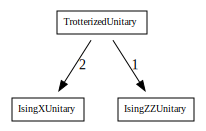

#### Counts totals:
 - `IsingXUnitary`: 2
 - `IsingZZUnitary`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
trott_unitary_g, trott_unitary_sigma = trott_unitary.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(trott_unitary_g)
show_counts_sigma(trott_unitary_sigma)